In [1]:
%matplotlib inline
import numpy as np
import scipy as sp

import pandas

import numpy.linalg as LA
import scipy.linalg as SLA

from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def QR_house(A):
    m,n = A.shape;
    V = np.zeros([m,n],dtype=np.float);
    R = np.empty([m,n],dtype=np.float);
    R[:] = A;
    for k in range(n):
        v = R[k:,k].ravel();
        v[0] = sign(v[0])*LA.norm(v) + v[0];
        v /= LA.norm(v);
        V[k:,k] = v;
        R[k:, k:] = R[k:, k:] - 2 * np.einsum("i,j,jk->ik",v, v, R[k:,k:]);

    Q = np.eye(m,n);
    for j in range(n):
        for k in range(n)[::-1]:
            Q[k:,j] = Q[k:,j] - 2 * np.einsum("i,i->",V[k:, k],Q[k:,j]) * V[k:, k];
    return Q,R[:n,:]

In [3]:
sns.set_style("white")

In [4]:
data1 = np.loadtxt('ds1.txt');
n_items1,n_month1 = data1.shape
data2 = np.loadtxt('ds2.txt');
n_items2,n_month2 = data1.shape

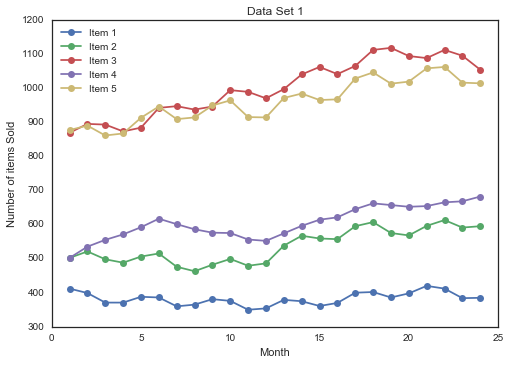

In [5]:
for i in range(n_items1):
    plt.plot(range(1,n_month1+1),data1[i,:],"o-", label="Item " + str(i+1))
plt.legend(loc=2)
plt.xlabel("Month")
plt.ylabel("Number of items Sold")
plt.title("Data Set 1")
plt.show()

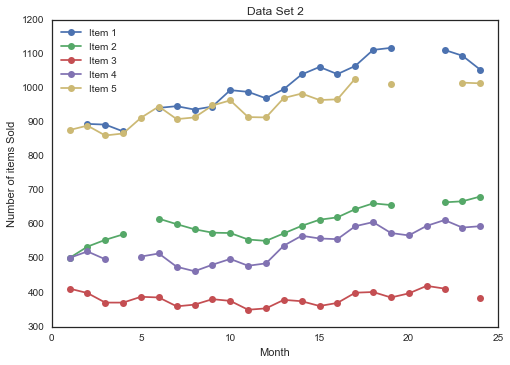

In [6]:
for i in range(n_items2):
    plt.plot(range(1,n_month2+1),data2[i,:],"o-", label="Item " + str(i+1))
plt.legend(loc=2)
plt.xlabel("Month")
plt.ylabel("Number of items Sold")
plt.title("Data Set 2")
plt.show()

#### 2. Basis Regression Model

\begin{equation}
x_{:,t} = at + b + \sum^4_{i=1} c^{(4)}_i \, \mathcal{I}(t \equiv i \ (\text{mod}\ 4))  + \sum^{12}_{i=1} c^{(12)}_i \, \mathcal{I}(t \equiv i \ (\text{mod}\ 12)) + \sum^{24}_{i=1} c^{(24)}_i \, \mathcal{I}(t \equiv i \ (\text{mod}\ 24))
\end{equation}

\begin{equation}
w = \begin{bmatrix}
a & b & 
c^{(4)}_1 & \cdots & c^{(4)}_4 &
c^{(12)}_1 & \cdots & c^{(12)}_{12} &
c^{(24)}_1 & \cdots & c^{(24)}_{24}
\end{bmatrix}^T
\end{equation}

\begin{equation}
A = \begin{bmatrix}
1 & 1 & 1 & 0 & \cdots \\
2 & 1 & 0 & 1 & \cdots \\
3 & 1 & 0 & 0 & \cdots \\
4 & 1 & 0 & 0 & \cdots \\
5 & 1 & 1 & 0 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{bmatrix}
\end{equation}

\begin{equation}
x = \begin{bmatrix}
x_{:,1} & x_{:,2} & \cdots  
\end{bmatrix}^T
\end{equation}

In [7]:
def construct_basis(l,n_month):
    A = np.zeros([n_month-l+1,2+4+12+24],dtype = np.float)
    A[:,0] = np.arange(l,n_month+1)
    A[:,1] = np.ones([n_month-l+1])
    for i in range(1,5):
        A[:,1+i] = np.array([j%4 == i for j in range(l,n_month+1)])
    for i in range(1,13):
        A[:,5+i] = np.array([j%12 == i for j in range(l,n_month+1)])
    for i in range(1,25):
        A[:,17+i] = np.array([j%24 == i for j in range(l,n_month+1)])
    return A

In [8]:
A = construct_basis(1,n_month1)
x = data1.T

#### 3. Least Squares by Normal Equations, QR and SVD

In basis regression model, I have assumed the fluctuations, linear coefficient and constants are specific to item. 

In [9]:
def solve_normal(A,b):
    # What it should do if A'*A would become positive definite
    # L = LA.cholesky(A.T.dot(A));
    # Ab = A.T.dot(b);
    # w = LA.solve(L,Ab);
    # return LA.solve(L.T,w);
    return LA.lstsq(A.T.dot(A),A.T.b)[0]

In [10]:
def solve_QR(A,b):
    Q,R = LA.qr(A,mode='reduced')
    # return LA.solve_triangular(R,Q.T.dot(b))[0]
    x = LA.lstsq(R,Q.T.dot(b))[0]
    return x

In [11]:
def solve_SVD(A,b):
    U,S,V = LA.svd(A, full_matrices=False);
    x = (V.T).dot(np.diag(1/S)).dot(U.T).dot(b);
    return x

In [12]:
w_norm = solve_SVD(A,x)
w_qr = solve_QR(A,x)
w_svd = solve_SVD(A,x)

In [13]:
A_pred = construct_basis(n_month1+1,n_month1+6)
A_pred.shape

(6L, 42L)

In [14]:
pred = np.empty([3,n_items1*6],dtype=np.float)
pred[0,:] = A_pred.dot(w_norm).reshape(-1)
pred[1,:]= A_pred.dot(w_qr).reshape(-1)
pred[2,:] = A_pred.dot(w_svd).reshape(-1)

In [15]:
diff = np.array([[LA.norm(pred[i,:]-pred[j,:])/LA.norm(pred[i,:]) for j in range(3)] for i in range(3)])
pandas.DataFrame(diff, ["NormE","QR","SVD"], ["NormE","QR","SVD"])

,NormE,QR,SVD
NormE,0.000000e+00,9.200492e-15,0.000000e+00
QR,9.200492e-15,0.000000e+00,9.200492e-15
SVD,0.000000e+00,9.200492e-15,0.000000e+00


#### 4,5. Ground Truth Test and Predictions

In [16]:
testdata1 = np.loadtxt('ds1.txt');
def project1(salesdata,testdata=None):
    pred = A_pred.dot(w_svd)
    if testdata != None:
        dist = LA.norm(testdata - pred.T, axis=1)
        print "Errors(Euclidean Norm):"
        for i,d in enumarate(dist):
            print "Item " + str(i+1) + ": " + str(d)
    return pred.T

#### 6,7,8. Historical Sales

\begin{equation}
w = \begin{bmatrix}
w_{1,1,1} & w_{1,1,2} & \cdots & w_{1,2,1} & w_{1,2,2} & \cdots & w_{2,1,1} & w_{2,1,2} & \cdots
\end{bmatrix}^T
\end{equation}

\begin{equation}
x = \begin{bmatrix}
x_{1,2} & x_{1,3} & \cdots  
\end{bmatrix}^T
\end{equation}

In [17]:
x = data1.reshape(-1)

In [18]:
def triple2single(i,j,tau,n_items,D_tau):
    return D_tau*(n_items*i+j)+tau

In [19]:
def single2triple(n,n_items,D_tau):
    tau = n % D_tau
    n = (n - tau)/D_tau
    j = n % n_items
    i = (n-j) /n_items
    return i,j,tau

In [20]:
def double2single(i,t,n_month):
    return t + n_month*i

In [21]:
def single2double(n,n_month):
    t = n % n_month
    i = (n - t)/n_month
    return i,t

In [22]:
def project_part2(salesdata,D_tau,testdata=None):
    n_items,n_month = salesdata.shape
    x = salesdata[:,1:].reshape(-1)
    
    A = np.zeros([x.size,D_tau*n_items**2])
    for i1 in range(A.shape[0]):
        i,t = single2double(i1,n_month)
        for tau in range(min(D_tau,t)):
            for j in range(n_items):
                A[i1,triple2single(i,j,tau,n_items,D_tau)] = salesdata[j,t-tau-1]
    
    v = LA.lstsq(A,x)[0]
    w = v.reshape((n_items,n_items,D_tau))
    
    t = n_month
    x_pred = np.zeros(n_items)
    for i in range(n_items):
        for tau in range(min(D_tau,t)):
                for j in range(n_items):
                    x_pred[i] += w[i,j,tau]*salesdata[j,t-tau-1]
    
    if testdata != None:
        print "Error: ",LA.norm(testdata - x_pred)
            
    return w,x_pred

In [23]:
project_part2(data1,5)[1]

array([  573.61275808,   951.32127095,   527.15751597,  1017.46277736,
        1189.10463693])